<a href="https://colab.research.google.com/github/ykitaguchi77/PCAF_AI_Project/blob/main/Regression_PCscar_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from __future__ import print_function, division
# !pip install torch_optimizer

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import torch
import torch.nn as nn
#import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image
from torch.cuda.amp import autocast, GradScaler


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')



GPU 0: Tesla T4 (UUID: GPU-a96e5f0a-067e-0097-a81d-2b2eb7daaebc)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# zip fileを解凍。/content/imagesへ。

import zipfile
zip_parent_path = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Cropped_images"
zip_name = ["Patient_1_Cropped.zip", "Patient13R_Cropped.zip"]
extract_path = "/content/images"

for zip_file in zip_name:
  zip_file_path = os.path.join(zip_parent_path, zip_file)
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print(f"Successfully extracted {zip_file} to {extract_path}")
  except FileNotFoundError:
    print(f"Error: {zip_file} not found at {zip_file_path}")
  except zipfile.BadZipFile:
    print(f"Error: {zip_file} is not a valid zip file.")
  except Exception as e:
    print(f"An unexpected error occurred while extracting {zip_file}: {e}")


Successfully extracted Patient_1_Cropped.zip to /content/images
Successfully extracted Patient13R_Cropped.zip to /content/images


In [3]:
csv_path = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Cropped_images/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv"
cropped_img_dir = "/content/images/Patient_1_Cropped"

#Patientとphaseを指定して画像を抜き出し
first_characters = "pt1_2_0M"

df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith(first_characters)]

filtered_df.head()

,Track Number,File Prefix1,File Prefix2,Pixels Prefix1,Pixels Prefix2,Ratio
0,1,pt1_2_0M_Photo_label0_track1.png,pt1_4_2Y_Photo_label0_track1.png,918,1020,1.111111
1,2,pt1_2_0M_Photo_label0_track2.png,pt1_4_2Y_Photo_label0_track2.png,957,810,0.846395
2,3,pt1_2_0M_Photo_label0_track3.png,pt1_4_2Y_Photo_label0_track3.png,837,864,1.032258
3,4,pt1_2_0M_Photo_label0_track4.png,pt1_4_2Y_Photo_label0_track4.png,1189,864,0.726661
4,5,pt1_2_0M_Photo_label0_track5.png,pt1_4_2Y_Photo_label0_track5.png,728,506,0.695055


TRAIN_dataset_size：798
VAL_dataset_size：199
TEST_dataset_size：199


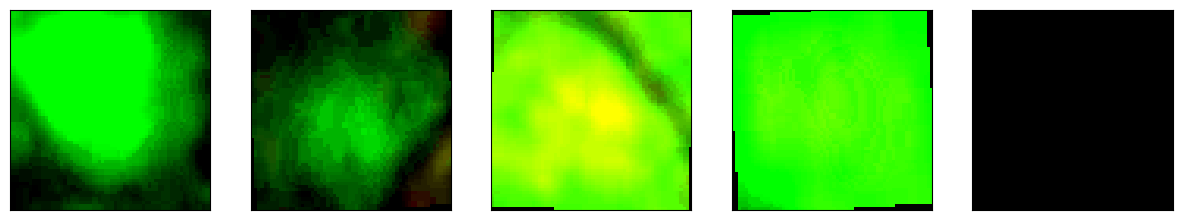

In [37]:
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.ratio = []

        self.item_paths = [os.path.join(self.folder_path, i) for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# Augmentation param
PX = 64 #画像のサイズ
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]
TRAIN_CROP_SCALE =(0.75,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.05
TRAIN_CONTRAST_PARAM = 0.05
TRAIN_SATURATION_PARAM = 0.05
TRAIN_RANDOM_ROTATION = 5
TRAIN_HUE_PARAM = 0.005
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]

# Training param
PATIENCE = 20
EPOCH = 100
BATCH_SIZE = 16


# Update the transform compositions using v2
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
    transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM,
                  contrast=TRAIN_CONTRAST_PARAM,
                  saturation=TRAIN_SATURATION_PARAM,
                  hue=TRAIN_HUE_PARAM),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=TRAIN_NORMALIZE_PARAM[0],
                       std=TRAIN_NORMALIZE_PARAM[1]),
])

val_data_transforms = transforms.Compose([
    transforms.Resize((PX, PX), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=TRAIN_NORMALIZE_PARAM[0],
                       std=TRAIN_NORMALIZE_PARAM[1]),
])

train_df = filtered_df.sample(frac=0.8, random_state=42)
val_df = filtered_df.drop(train_df.index)

train_dataset = SimpleImageDataset(cropped_img_dir, train_df, train_data_transforms)
val_dataset = SimpleImageDataset(cropped_img_dir, val_df, val_data_transforms)
test_dataset = SimpleImageDataset(cropped_img_dir, val_df, train_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)


print("TRAIN_dataset_size：" + str(len(train_dataset)))
print("VAL_dataset_size：" + str(len(val_dataset)))
print("TEST_dataset_size：" + str(len(test_dataset)))



#水増し後の画像を可視化する関数
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        plt.imshow(image)


#画像の可視化
show_img(train_dataset)



In [52]:
from torchvision.models import ResNet18_Weights

# class LaserSpotResNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # ResNet18をベースに転移学習 - pretrainedの代わりにweightsを使用
#         self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#         # 入力層を64x64x3に対応
#         self.resnet.conv1 = nn.Conv2d(3, 64, 7, stride=1, padding=3)
#         self.resnet.maxpool = nn.MaxPool2d(2, stride=2)
#         # 回帰のための出力層
#         self.resnet.fc = nn.Sequential(
#             nn.Linear(512, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 1)
#         )

#     def forward(self, x):
#         return self.resnet(x)

class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # ResNet18をベースに転移学習
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # 入力層を64x64x3に対応
        self.resnet.conv1 = nn.Conv2d(3, 64, 7, stride=1, padding=3)
        self.resnet.maxpool = nn.MaxPool2d(2, stride=2)

        # 回帰のための出力層を改良
        self.resnet.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # BatchNormを追加
            nn.ReLU(),
            nn.Dropout(0.3),      # 最初のDropoutは少し控えめに

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  # BatchNormを追加
            nn.ReLU(),
            nn.Dropout(0.5),      # 後ろの層ほどDropoutを強めに

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.resnet(x)

# モデル定義
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = LaserSpotResNet().to(device)

# 学習設定 - 重複している最適化設定を統合
criterion = nn.MSELoss()
# optimizer = optim.AdamW(model_ft.parameters(), lr=1e-4, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.1,
#     patience=10,
#     min_lr=1e-6,
# )

# オプティマイザーとスケジューラーの設定
optimizer = torch.optim.AdamW(
    model_ft.parameters(),
    lr=1e-3,          # 初期学習率
    weight_decay=0.01,  # L2正則化
    betas=(0.9, 0.999)
)

# ステップ数の計算
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCH

# OneCycleLRスケジューラー
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,          # 最大学習率
    total_steps=total_steps,
    pct_start=0.3,        # warmupの割合
    anneal_strategy='cos',
    div_factor=25.0,      # 初期学習率 = max_lr/25
    final_div_factor=1e4  # 最終学習率 = max_lr/(25*1e4)
)



#**Modules**

In [53]:
####################################
####################################
#Test with early-stopping
####################################
####################################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):
    # steps_per_epochの計算
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * n_epochs

    # OneCycleLRの設定
    scheduler = lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4
    )

    # AMP用のscalerを初期化
    scaler = torch.cuda.amp.GradScaler()

    # 損失の記録用リスト
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []

    # early stoppingの初期化
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):
        ###################
        # train the model #
        ###################
        model.train()
        running_corrects, train_acc = 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # 勾配をゼロに初期化
            optimizer.zero_grad()

            # AMPを使用した順伝播
            with torch.cuda.amp.autocast():
                output = model(image_tensor)
                loss = loss_func(output, target)

            # AMPを使用した逆伝播
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # OneCycleLRはバッチごとに更新
            scheduler.step()

            # 現在の学習率を記録
            current_lr = optimizer.param_groups[0]['lr']

            train_losses.append(loss.item())

        ######################
        # validate the model #
        ######################
        model.eval()
        running_corrects, val_acc = 0, 0

        with torch.no_grad():
            for image_tensor, target in val_loader:
                target = target.view(len(target), 1)

                image_tensor = image_tensor.to(device)
                target = target.to(device)

                # 評価時もAMPを使用
                with torch.cuda.amp.autocast():
                    output = model(image_tensor)
                    loss = loss_func(output, target)

                valid_losses.append(loss.item())

        # 平均損失の計算
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                    f'train_loss: {train_loss:.5f} ' +'\n'
                    f'valid_loss: {valid_loss:.5f} ' +'\n'
                    f'learning_rate: {current_lr:.2e}')
        print(print_msg)

        # リストのクリア
        train_losses = []
        valid_losses = []

        # early stopping
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 最良のモデルを読み込み
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses



#**Train model & save network**

<ipython-input-53-fba108429598>:75: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-53-fba108429598>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
<ipython-input-53-fba108429598>:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.

Epoch: [  1/100] 
train_loss: 1.16542 
valid_loss: 1.02704 
learning_rate: 4.26e-05
Validation loss decreased (inf --> 1.027040).  Saving model ...
Epoch: [  2/100] 
train_loss: 0.94919 
valid_loss: 0.98003 
learning_rate: 5.05e-05
Validation loss decreased (1.027040 --> 0.980028).  Saving model ...
Epoch: [  3/100] 
train_loss: 0.78272 
valid_loss: 0.62442 
learning_rate: 6.35e-05
Validation loss decreased (0.980028 --> 0.624415).  Saving model ...
Epoch: [  4/100] 
train_loss: 0.69696 
valid_loss: 0.61008 
learning_rate: 8.16e-05
Validation loss decreased (0.624415 --> 0.610076).  Saving model ...
Epoch: [  5/100] 
train_loss: 0.57183 
valid_loss: 0.49254 
learning_rate: 1.04e-04
Validation loss decreased (0.610076 --> 0.492539).  Saving model ...
Epoch: [  6/100] 
train_loss: 0.48512 
valid_loss: 0.38963 
learning_rate: 1.32e-04
Validation loss decreased (0.492539 --> 0.389629).  Saving model ...
Epoch: [  7/100] 
train_loss: 0.41438 
valid_loss: 0.29496 
learning_rate: 1.63e-04
Val

<ipython-input-53-fba108429598>:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


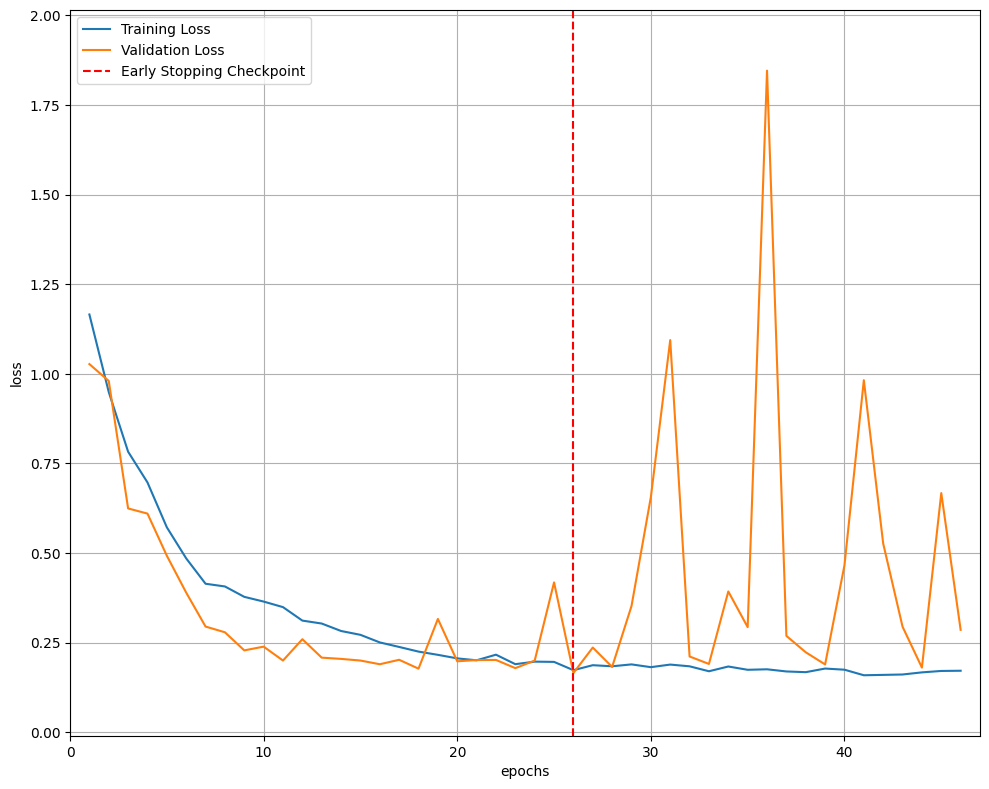

In [54]:
model, train_loss, valid_loss = train_model(model_ft, criterion, BATCH_SIZE, optimizer, PATIENCE, EPOCH, device)

#ネットワークの保存
PATH = 'test.pth'
torch.save(model_ft.state_dict(), PATH)

# Drawing learning curves
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

# データの最小値と最大値を取得
min_loss = min(min(train_loss), min(valid_loss))
max_loss = max(max(train_loss), max(valid_loss))

# マージンを追加して少し余裕を持たせる（例：10%のマージン）
margin = (max_loss - min_loss) * 0.1
plt.ylim(min_loss - margin, max_loss + margin)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#**Evaluation using testset**

In [55]:
PATH = 'test.pth'
model_ft.load_state_dict(torch.load(PATH))

<ipython-input-55-0d5ce215a03f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(PATH))


<All keys matched successfully>

#**Result analysis**

In [56]:
import statistics

def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:
      target = target.view(len(target), 1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)

      outputs.append((output[0]*100).item())
      targets.append((target[0]*100).item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append((output[0]*100).item()-(target[0]*100).item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))


#csvを作成して保存
columns = ["result"]
index = ["AveError", "StdError", "AveAbsError", "StdAbsError", "Corrected_AveAbsError", "Corrected_StdAbsError"]
df = pd.DataFrame(index=index, columns=columns)
df.iloc[0:6, 0] =[statistics.mean(errors),statistics.stdev(errors),statistics.mean(AbsError),statistics.stdev(AbsError), statistics.mean(corrected_AbsError),statistics.stdev(corrected_AbsError)]
print(df)

PATH = 'test.csv'
df.to_csv(index=True)

AveError: -8.606291871574056
StdError: 40.55108354899578
AveAbsError: 29.85946238340445
StdAbsError: 28.683484061912214
Corrected_AveAbsError: 29.303464412075115
Corrected_StdAbsError: 27.952826636683103
                          result
AveError               -8.606292
StdError               40.551084
AveAbsError            29.859462
StdAbsError            28.683484
Corrected_AveAbsError  29.303464
Corrected_StdAbsError  27.952827


',result\nAveError,-8.606291871574056\nStdError,40.55108354899578\nAveAbsError,29.85946238340445\nStdAbsError,28.683484061912214\nCorrected_AveAbsError,29.303464412075115\nCorrected_StdAbsError,27.952826636683103\n'

<ipython-input-63-d49ee54860ec>:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<Figure size 640x480 with 0 Axes>

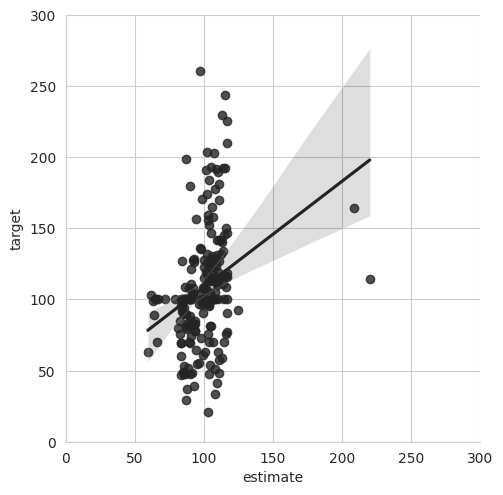

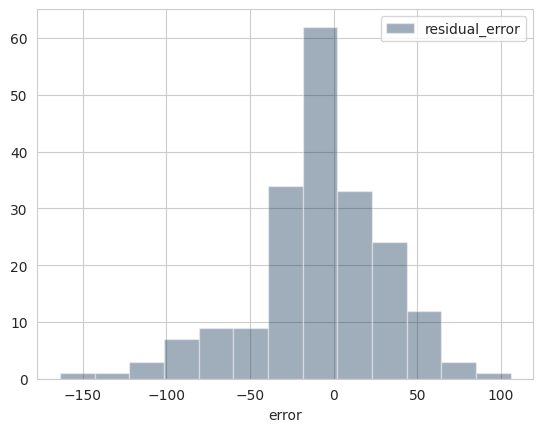

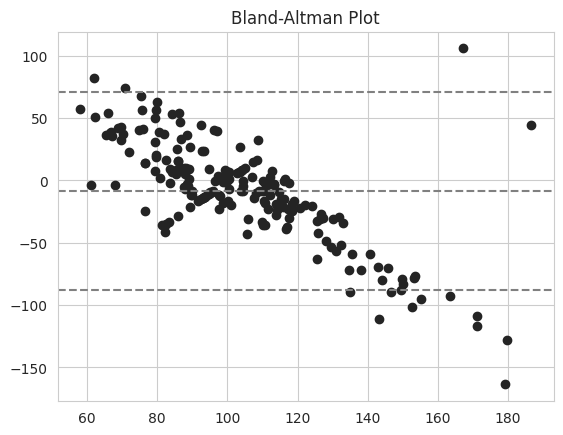

In [63]:
import seaborn as sns

#Draw Graphs（散布図)
df = pd.DataFrame({'estimate':outputs, 'target':targets})


#Scatterplot
plt.figure()
sns.set_style('whitegrid')
sns.set_palette('gray')
figure = sns.lmplot(x='estimate', y='target', data=df)
plt.xlim(0,300)
plt.ylim(0,300)




PATH = 'test.png'
figure.savefig(PATH)



#Draw histogram
plt.figure()

df['error']=""
for i in range(len(df)):
    df.iloc[i,2] = df.iloc[i,0]-df.iloc[i,1]

sns.distplot(
    df['error'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示



#Bland-Altman-Plot
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputs, targets)
plt.title('Bland-Altman Plot')
plt.show()

#**結果をCSVファイルに記載**

In [ ]:
#result.csv作成（ファイルがなければ）
if os.path.exists(FILENAME_RESULTCSV) == False:
    df_result = df_labelcsv.copy()
else:
    print(FILENAME_RESULTCSV + " already exists!")

df_result = pd.read_csv(FILENAME_RESULTCSV, index_col=0)
print(df_result)


"""
################
#df_resultを初期化
################

df_result = df_labelcsv.copy()
df_result["set"] = "0"  #工程の列を追加

#valフォルダ内のファイル名を取得
train_data_path = glob.glob(DATASET_NAME + "/" + TRAIN_FOLDER_NAME+"/*")
val_data_path = glob.glob(DATASET_NAME + "/" + VAL_FOLDER_NAME+"/*")
test_data_path = glob.glob(DATASET_NAME + "/" + TEST_FOLDER_NAME+"/*")

for i in train_data_path:
    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "train"
for i in val_data_path:
    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "val"
for i in test_data_path:
    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "test"

print(df_result)
"""

result.csv already exists!
                   filename  age  ... cropped_A2  cropped_A2_pretrained
0     img00085008_00_1R.jpg   61  ...  42.550665              51.511717
1     img00085024_00_1R.jpg   29  ...  39.297953              27.813551
2     img00241280_10_1R.jpg   51  ...  50.525779              57.090443
3     img00265140_00_1R.jpg   29  ...  37.621737              31.148827
4     img00265140_00_2L.jpg   29  ...  45.709464              28.956094
...                     ...  ...  ...        ...                    ...
1409  img76791392_10_1R.jpg   38  ...  27.728298              35.313144
1410  img76843122_10_1R.jpg   49  ...  54.683352              42.622042
1411  img76843122_11_1R.jpg   49  ...  51.311404              44.966671
1412  img76888512_00_1R.jpg   74  ...  55.601197              67.208940
1413  img76888512_00_2L.jpg   74  ...  57.358873              79.072827

[1414 rows x 6 columns]


'\n################\n#df_resultを初期化\n################\n\ndf_result = df_labelcsv.copy()\ndf_result["set"] = "0"  #工程の列を追加\n\n#valフォルダ内のファイル名を取得\ntrain_data_path = glob.glob(DATASET_NAME + "/" + TRAIN_FOLDER_NAME+"/*")\nval_data_path = glob.glob(DATASET_NAME + "/" + VAL_FOLDER_NAME+"/*")\ntest_data_path = glob.glob(DATASET_NAME + "/" + TEST_FOLDER_NAME+"/*")\n\nfor i in train_data_path:\n    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "train"\nfor i in val_data_path:\n    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "val"\nfor i in test_data_path:\n    df_result.loc[df_result.iloc[:,0] == os.path.basename(i), "set"] = "test"\n\nprint(df_result)\n'

In [ ]:
#Calculating result

#対象のパスからラベルを抜き出して表示
def getlabel(result_csv, image_name):
      image_name = image_name
      label = df_result[df_result.iloc[:,0] == image_name].iloc[0,1] #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得
      return(image_name, label)


#評価のための画像下処理
def image_transform(image_path):
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor()])
    image_tensor = transform(image)


    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)


def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


#モデルにした処理した画像を投入して予測結果を出力
def image_eval(image_tensor, model_ft):
    output = model_ft(image_tensor).item()*100
    return output

#result.csvに結果を記入
def write_result(df, image_name, pred, row):
    df.loc[df_result.iloc[:,0] == image_name, row] = pred  #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得




#ここからがメイン
model_ft.eval() # prep model for evaluation

#valフォルダ内のファイル名を取得
train_data_path = glob.glob(DATASET_NAME + "/" + TRAIN_FOLDER_NAME+"/*")
val_data_path = glob.glob(DATASET_NAME + "/" + VAL_FOLDER_NAME+"/*")
test_data_path = glob.glob(DATASET_NAME + "/" + TEST_FOLDER_NAME+"/*")

data_path = [train_data_path, val_data_path, test_data_path]
k=0
for j in data_path:
    for i in j:
          image_name, label = getlabel(df_result, os.path.basename(i))  #画像の名前とラベルを取得
          image_tensor = image_transform(i)  #予測のための画像下処理
          pred = image_eval(image_tensor, model_ft)  #予測結果を出力
          write_result(df_result, image_name, pred, MODEL_NAME)
          print(str(k)+"/"+str(len(df_result)) + " images processed!")
          k+=1
print(df_result)

0/1414 images processed!
1/1414 images processed!
2/1414 images processed!
3/1414 images processed!
4/1414 images processed!
5/1414 images processed!
6/1414 images processed!
7/1414 images processed!
8/1414 images processed!
9/1414 images processed!
10/1414 images processed!
11/1414 images processed!
12/1414 images processed!
13/1414 images processed!
14/1414 images processed!
15/1414 images processed!
16/1414 images processed!
17/1414 images processed!
18/1414 images processed!
19/1414 images processed!
20/1414 images processed!
21/1414 images processed!
22/1414 images processed!
23/1414 images processed!
24/1414 images processed!
25/1414 images processed!
26/1414 images processed!
27/1414 images processed!
28/1414 images processed!
29/1414 images processed!
30/1414 images processed!
31/1414 images processed!
32/1414 images processed!
33/1414 images processed!
34/1414 images processed!
35/1414 images processed!
36/1414 images processed!
37/1414 images processed!
38/1414 images process

In [ ]:
#Resultファイルを書き出し
df_result.to_csv(FILENAME_RESULTCSV)